# Element agnostic system

NN model takes (1, 151) input sample and outputs (1, 6) array of 6 h width values. The sphere element structure is predefined beforehand.

Input (1, 151) - absorbed power sampled over visible spectrum (from 400 to 700 nm)

Output (1, 6) - sphere layer deisgn [h1, h2, h3, h4, h5, h6]

NN model consists of 6 layers (5 hidden + 1 ouput)

Batch normalization layers, dropout (60%), and LeakyReLU

Evaluation metrics: RMSE and MAE

K-fold cross validation

Adam optimizer with He-Xavier initial weights

Learning rate array [0.0001, 0.001, 0.01]

Number of neurons per layer array [100, 200, 300, 400, 500, 600]

Early stopping criteria is used

In [ ]:
# important libraries import

import pandas as pd
import numpy as np
import torch
from torch import nn
import sys
import statistics as st
import copy
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
# check GPU memory state

!nvidia-smi

In [ ]:
# CUDA check

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

In [ ]:
%ls

In [ ]:
# dataset import and training flag selection

data_distribution = "Normal"
#data_distribution = "Uniform"

data_normalized_flag = True
includes_source_distance = True
polarization_mode = "TE"

pd_x_train_val = pd.read_csv('./Data_40k/processed/X_train_TE.csv', header=None);
pd_y_train_val = pd.read_csv('./Data_40k/processed/y_train_te.csv', header=None);
#pd_ym_train_val = pd.read_csv('./Data/y_train_tm.csv', header=None);

# train-val dataset

#pd_x_train_val = pd.read_csv('./Data_Normal/X_train.csv', header=None);
#pd_ye_train_val = pd.read_csv('./Data_Normal/y_train_te.csv', header=None);
#pd_ym_train_val = pd.read_csv('./Data_Normal/y_train_tm.csv', header=None);

In [ ]:
# from pandas to numpy

X = np.array(pd_x_train_val)
y = np.array(pd_y_train_val)
#ym = np.array(pd_ym_train_val)

In [ ]:
# converting to nano-meter scale
# here, the sphere width deisgn as [h1, h2, h3, h4, h5, h6]
# where h1 is the outer layer and h5 is the core, h6 is the distance from source to sphere surface

X = X*(10**9)
print(X)

In [424]:
# photonic response sampled on the 151 visible wavelength spectrum (between 400 and 700 nm)
print(X.shape)
print(y.shape)

(8722, 6)
(8722, 151)


In [413]:
for i in range(len(X)):
    if np.isnan(y[i]).any():
        y[i] = 0
        X[i] = 0

In [414]:
# photonic response sampled on the 151 visible wavelength spectrum (between 400 and 700 nm)
print(X.shape)
print(y.shape)

(8722, 6)
(8722, 151)


In [415]:
y=y[~np.all(y == 0, axis=1)]
X=X[~np.all(X == 0, axis=1)]

In [416]:
print(y.shape)
print(X.shape)

(8722, 151)
(8722, 6)


In [331]:
# standartization/normalization of the dataset if flag is True

if data_normalized_flag:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print("X data")
    print(X)
    
   

X data
[[-2.40138481 -0.21418128  0.6362451   0.42478585  0.19329606 -0.03297668]
 [ 0.51970702 -0.1569186   0.36563874  0.17227415 -0.22658189 -2.0100255 ]
 [ 0.03638795 -0.58504611 -0.81096193 -0.26892396 -0.29808117  2.34103073]
 ...
 [ 0.52994894 -1.14189584 -0.91571557  0.89656981  0.0439697  -0.42541753]
 [ 0.29720312  1.13389919 -1.60355742  0.05240135  1.11832675  0.03441326]
 [-2.39763196  0.19894311  0.64874194 -1.66737829  0.5202913  -0.23319817]]


In [369]:
for i in range(151):
    y_max = np.amax(y[:,i])
    y_min = np.amin(y[:,i])
    y[:,i] = (y[:,i]-y_min)/(y_max-y_min)
print("\nY data")
print(y)


Y data
[[0.61493986 0.61253597 0.61113883 ... 0.28286152 0.27896138 0.27642459]
 [0.29958144 0.29869481 0.29749739 ... 0.21283314 0.20688677 0.20226998]
 [0.21782272 0.21065997 0.20324019 ... 0.04783514 0.04276202 0.03924474]
 ...
 [0.26440293 0.25849007 0.25221702 ... 0.13216763 0.1272297  0.12368138]
 [0.28395917 0.28446246 0.2853983  ... 0.32458221 0.31686477 0.31035209]
 [0.49766355 0.50318388 0.510045   ... 0.27481691 0.27275418 0.27192545]]


# DATA VISUALIZATION

In [333]:
# copy of dataset to make a comparative distribution plot

df1 = pd_x_train_val*(10**9)


In [334]:
df2 = pd_y_train_val

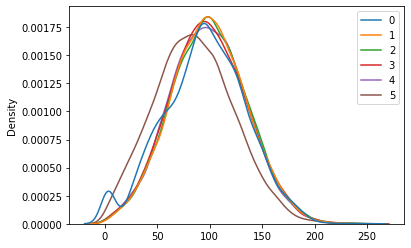

In [335]:
# PDF of X (h width values)

sns.kdeplot(data=df1)

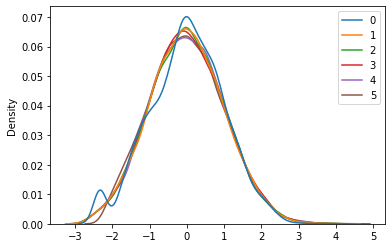

In [336]:
# PDF of standartized X (h width values)

sns.kdeplot(data=X)

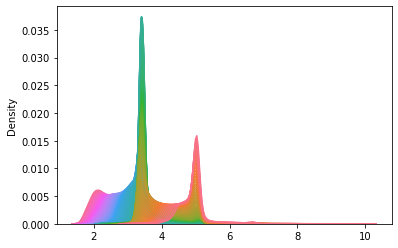

In [337]:
# PDF of y (photonic response)

sns.kdeplot(data=df2.iloc[:,:], legend=False)

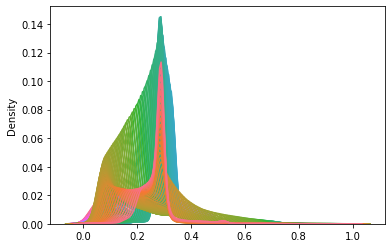

In [338]:
# PDF of normalized y (photonic response)

sns.kdeplot(data=y, legend=False)

# DATA LOADING METHOD

In [425]:
# dataset loader function, for traning and validation loaders

def data_loader(batch_size, x_train, y_train, x_val, y_val):
    
    train_dataset = TensorDataset(y_train, x_train)
    val_dataset = TensorDataset(y_val, x_val)
    
    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size = batch_size, 
                              shuffle = True)
    
    val_loader = DataLoader(dataset = val_dataset, 
                            batch_size = batch_size, 
                            shuffle = True)
    
    return train_loader, val_loader

# NN MODEL DEFINITION

In [480]:
# main NN model definition

class NeuralNetwork(nn.Module):
    def __init__(self, layer_size):
        
        super(NeuralNetwork, self).__init__()
        self.main = nn.Sequential(
            
            nn.Linear(151, layer_size),
            nn.BatchNorm1d(layer_size),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            
            nn.Linear(layer_size, layer_size),
            nn.BatchNorm1d(layer_size),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
                           
            nn.Linear(layer_size, layer_size),
            nn.BatchNorm1d(layer_size),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            
            nn.Linear(layer_size, layer_size),
            nn.BatchNorm1d(layer_size),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            
            nn.Linear(layer_size, layer_size),
            nn.BatchNorm1d(layer_size),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            
            nn.Linear(layer_size, 6),
        )
    def forward(self, input):
         return self.main(input)

def make_train_step(model, loss_fn, optimizer, loss_type):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        if loss_type == "loss_m":
            loss = torch.sqrt(loss_fn(yhat.view(-1), y.view(-1)))
        else:
            loss = loss_fn(yhat.view(-1), y.view(-1))
        # Computes gradients
        #loss = loss_fn(yhat.view(-1), y.view(-1))
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    # Returns the function that will be called inside the train loop
    return train_step

# WEIGHTS INITIALIZATION

In [481]:
# Xavier weights initialization

def init_weights(m):
    
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


# model complexity calculation
        
def model_complexity(model):
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('Total: \t\t', pytorch_total_params/10**6)
    pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    print('Trainable: \t\t', pytorch_train_params/10**6)
    
    return (pytorch_train_params/10**6)

# IDEAL-FLAT RESPONSE AND OPTIMAL DESIGN GENERATION  

In [482]:
# function to gradually feed the already-trained model with ideal flat photonic response
# starting from 1 to 200 threshold, we feed a 1x151 vectors starting from [1, 1, 1, ..., 1] to [200, 200, 200, ..., 200]
# The trained NN model outputs the corresponding optimal design in response to the ideal flat response 

def increase(bestmodel):
    
    bestmodel.eval()
    
    if includes_source_distance:
        expected = torch.ones(1,6)
    else:
        expected = torch.ones(1,5)
        
    threshold = 10
    j = 0
    vals_arr = []
    threshold_arr = []
    
    while threshold < 50:
        vals = expected
        threshold = (1+j)
        j=j+0.25
        
        true_x_np = threshold * np.ones((1,151))
        true_x = torch.from_numpy( true_x_np.reshape(1,151) ).float()
        expected = bestmodel(true_x.to(device)).view(1,-1)
        vals_arr.append(expected.cpu().data.numpy())
        threshold_arr.append(threshold)
    
    vals_arr = np.array(vals_arr)
    vals_arr = vals_arr.reshape(vals_arr.shape[0],-1)
    threshold_arr = np.array(threshold_arr)
    
    print("Ideal response's array shapes:")
    print(vals_arr.shape)
    print(threshold_arr.shape)
    
    return vals_arr, threshold_arr 

# INAPPROPRIATE RESULTS FILTERING

In [483]:
# function to filter out negative samples generated by model so far

def extract_positive(vals_arr, threshold_arr):
    
    val_temp = []
    threshold_temp = []
    counter = 0
    
    main_val_matlab = []
    main_tr_matlab = []
    
    for i, row in enumerate(vals_arr):
        #if ((row < 1).any() == False)
        #(((row[0:5] >= 10).any() == True) and ((row[0:5] <= 100).any() == True)) and
        #and ((row[0]+row[1]+row[2]+row[3]+row[4] < row[5]) == True)
        #and ((row[0:6] > 1200).any() == False)
        if (row < 1).any() == False and (row[0:5] > 600).any() == False:
        #if ((row < 1).any() == False):

            val_temp.append(row)
            threshold_temp.append(threshold_arr[i])
            counter +=1
            
    print(counter)
    val_temp = np.array(val_temp)
    val_temp.shape
    
    threshold_temp = np.array(threshold_temp)
    threshold_temp.shape
    
    return  val_temp, threshold_temp

# MODEL PARAMETERS INITIALIZATION

In [484]:
# function to initialize the optimizer, model instance and other training stuff

def params_init(layer_size, learning_r, loss_main, loss_secondary):

    model = NeuralNetwork(layer_size).to(device)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_r)
    
    train_step_main = make_train_step(model, loss_main, optimizer, "loss_m")
    train_step_secondary = make_train_step(model, loss_secondary, optimizer, "loss_s")
    
    counter = 0
    
    return model, optimizer, train_step_main, train_step_secondary, counter

# MAIN TRAINING-VALIDATION SCRIPT

In [485]:
# the main function to train and validate the model

def train_main(part, train_loader, val_loader, args):
    
    device = args.device
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    records = pd.DataFrame(columns=['Part_Num', 'Learning_rate', 'Layer_size', 'best_val(RMSE)',\
                                    'last_val(MAE)', 'stopping epoch', 'counter',\
                                    'positive num', 'all'])
    
    lr_arr = np.array([0.0001, 0.0005]).reshape(-1,1)
    N_size = np.array([100, 200, 300, 400 ,500 ,600]).reshape(-1,1)
    
    #lr_arr = np.array([0.01, 0.05, 0.1, 0.5]).reshape(-1,1)
    #N_size = np.array([25, 50, 100, 150]).reshape(-1,1)
    
    for i, LR in enumerate(lr_arr):
        for j, LS in enumerate(N_size):
            
            Learning_rate = LR[0]
            Layer_size    = LS[0]
            
            ds = DataStore(part, Learning_rate, Layer_size)
            
            loss_main =  nn.MSELoss()
            #loss_secondary = MARE
            loss_secondary = nn.L1Loss()
            model, optimizer, train_step_main, train_step_secondary, counter = params_init(Layer_size, Learning_rate, \
                                                                                           loss_main, loss_secondary)
            complexity = model_complexity(model)
            
            print("%-10s\n %-15s %-4.6f \n %-15s %-4.2f\n %10s" %("////////////////////////",\
                                                                  "Learning Rate:", Learning_rate,\
                                                                  "Layer Size:",    Layer_size,\
                                                                  "////////////////////////"))
            
            bestmodel, best_val_error_main, best_val_error_secondary, counter, epoch = train_procedure(model, \
                                                                                                       train_step_main, \
                                                                                                       train_step_secondary, \
                                                                                                       loss_main, \
                                                                                                       loss_secondary, \
                                                                                                       train_loader, \
                                                                                                       val_loader, \
                                                                                                       args, \
                                                                                                       part, \
                                                                                                       Layer_size, \
                                                                                                       Learning_rate)
            
            ds.net_saver(bestmodel)
            vals_arr, threshold_arr = increase(bestmodel)
            val_temp, threshold_temp = extract_positive(vals_arr, threshold_arr)
            ds.dimensions_saver(val_temp, threshold_temp)
            #ds.dimensions_saver(vals_arr, threshold_arr)

            new_row = {'Part_Num': part, \
                       'Learning_rate': Learning_rate, \
                       'Layer_size': Layer_size, \
                       'best_val(RMSE)': best_val_error_main, \
                       'last_val(MAE)': best_val_error_secondary, \
                       'stopping epoch': epoch, \
                       'counter': counter, \
                       'positive num':val_temp.shape[0], \
                       'all': vals_arr.shape[0]}
            
            records = records.append(new_row, ignore_index=True)
    
    ds.records_saver(records)
    
    return lr_arr, N_size
    
    

# SECONDARY TRAINING-VALIDATION SCRIPT

In [486]:
# secondary main function to train and validate model

def train_procedure(model, train_step_main, train_step_secondary, loss_main, loss_secondary,
                    train_loader, val_loader, args, part, Layer_size, Learning_rate):
    
    n_epochs = args.epochs
    device = args.device
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    counter = 0
    i = 0
    k = 0
    
    tr_losses_main_global = []
    val_losses_main_global = []
    
    tr_losses_secondary_global = []
    val_losses_secondary_global = []
    
    best_val_error_main = 70000
    final_error_secondary = 70000
    
    for epoch in range(0, n_epochs):
        
        tr_losses_main = []
        tr_losses_secondary= []
        
        val_losses_main = []
        val_losses_secondary = []
        
        for x_batch, y_batch in train_loader:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            tr_loss_main = train_step_main(x_batch, y_batch)
            tr_losses_main.append(tr_loss_main)
            
            tr_loss_secondary = train_step_secondary(x_batch, y_batch)
            tr_losses_secondary.append(tr_loss_secondary)
            
        with torch.no_grad():
            model.eval()
            for x_val, y_val in val_loader:
                
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_hat = model(x_val)
                
                val_losses_main_temp = torch.sqrt(loss_main(y_hat, y_val))
                val_losses_secondary_temp = loss_secondary(y_hat, y_val)
                
                val_losses_main.append(val_losses_main_temp.item())
                val_losses_secondary.append(val_losses_secondary_temp.item())
            
            counter += 1
            
            if (st.mean(val_losses_main) < best_val_error_main):
                best_val_error_main = st.mean(val_losses_main)
                final_error_secondary = st.mean(val_losses_secondary)
                bestm = copy.deepcopy(model)
                counter = 1
            
            MSE_TR  = st.mean(tr_losses_main)
            MSE_VL  = st.mean(val_losses_main)
            MARE_TR = st.mean(tr_losses_secondary)
            MARE_VL = st.mean(val_losses_secondary)
            
            if  counter >= 1:
                print("%-5s %-i   %-5s %-i   %-10s %-4.9f   %-10s %-4.9f   %-10s %-4.9f   %-10s %-4.9f \n" % \
                      ("Epochs", epoch+1, "Counter", counter, \
                       "Train(RMSE):", np.round(MSE_TR,7), \
                       "Val(RMSE):", np.round(MSE_VL,7), \
                       "Train(MAE),%:", np.round( MARE_TR,7), \
                       "Val(MAE),%:", np.round(MARE_VL,7)))
            
            tr_losses_main_global.append(MSE_TR)
            val_losses_main_global.append(MSE_VL)
            tr_losses_secondary_global.append(MARE_TR)
            val_losses_secondary_global.append(MARE_VL)
            
            if counter == args.stopping_criterion:
                print('//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////')
                break;
    
    plt.plot(np.arange(1, epoch+2), tr_losses_main_global, color='green', label="RMSE Train")
    plt.plot(np.arange(1, epoch+2), val_losses_main_global, color='red', label="RMSE Val")
    plt.xlabel('Epoch')
    plt.ylabel('RMSE Loss')
    plt.title('Train-Val, Layer Size: ' + str(Layer_size) + ', Learning Rate: ' + str(Learning_rate))
    plt.legend()
    plt.savefig("./Results_Images/Part_" + str(part) + "_lr_" + str(Learning_rate) + "_layer_size_" + str(Layer_size) + ".png")
    plt.show()

    return bestm, best_val_error_main, final_error_secondary, counter, epoch+1

# DATA STORING METHODS

In [487]:
# data store to files

import os
import torch
import pandas as pd

class DataStore():
    def __init__(self, part, Learning_r, Layer_s):
        super().__init__()
        self.part = part
        self.Learning_r = Learning_r
        self.Layer_s = Layer_s
        self.results_dir = 'Results'
        self.part_number = 'Part_Number_' + str(self.part)
        self.folder_name = self.part_number + '_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s)
        self.part_dir = os.path.join(
            self.results_dir, self.part_number)
        self.checkpoint_dir = os.path.join(
            self.part_dir, self.folder_name)
        os.makedirs(self.part_dir, exist_ok = True)
        os.makedirs(self.checkpoint_dir, exist_ok = True)
        
    def net_saver(self, model_to_save):
        model_name = self.part_number + '_model_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s) + '.pt'
        model_path = os.path.join(self.checkpoint_dir, model_name)
        torch.save(model_to_save.state_dict(), model_path)
        print(model_name, 'Was saved successfully \t\t\t[saved]')
        
    def net_loader(self, path = None):
        testm = NN(self.Layer_s).to(device)
        if path is None:
            model_name = self.part_number + '_model_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s) + '.pt'
            path = os.path.join(self.checkpoint_dir, model_name)
            testm.load_state_dict(torch.load(path))
            print(model_name,' Was loaded successfully loaded.\t\t\t [loaded]')
        else:
            testm.load_state_dict(torch.load(path))
            print(model_name,' Was loaded successfully loaded from the path.\t\t\t [loaded from Path]')
        return testm
    
    def records_saver(self, records):
        self.records  = records
        self.name_records =  'Part_Number_' + str(self.part) + '_records.csv'
        self.records.to_csv(os.path.join(self.results_dir, self.name_records),index = True,header = True)
        
    def dimensions_saver(self, d_values, threshold):
        self.vals_matlab = pd.DataFrame(d_values)
        self.threshold_matlab = pd.DataFrame(threshold)
        name_vals = self.part_number  + '_vals_lr_'+ str(self.Learning_r) + '_layer_size_'+str(self.Layer_s)+'.csv'
        name_threshold = self.part_number  + '_threshold_lr_'+str(self.Learning_r) + '_layer_size_'+str(self.Layer_s)+'.csv'
        self.vals_matlab.to_csv(os.path.join(self.checkpoint_dir, name_vals), index = False, header = False)
        self.threshold_matlab.to_csv(os.path.join(self.checkpoint_dir, name_threshold), index = False, header = False)
        
def description_saver(lr, ls,
                      data_distribution, data_normalized_flag,
                      includes_source_distance, polarization_mode, args):
    
    f = open("./Results/Description.txt", "w")
    
    array = np.array2string(lr, separator=',')
    f.write("Learning rates: \n")
    f.write(array)
    f.write("\n\n")
    
    array = np.array2string(ls, separator=',')
    f.write("Layer sizes: \n")
    f.write(array)
    f.write("\n\n")
    
    f.write("Data distribution: " + str(data_distribution))
    f.write("\n")
    
    f.write("Data normalized flag: " + str(data_normalized_flag))
    f.write("\n")
    
    f.write("Includes source distance: " + str(includes_source_distance))
    f.write("\n")
    
    f.write("Polarization mode: " + str(polarization_mode))
    f.write("\n")
    
    f.write("Epochs: " + str(args.epochs))
    f.write("\n")
    
    f.write("Stopping criteria: " + str(args.stopping_criterion))
    f.write("\n")
    
    f.write("Batch size: " + str(args.batch_size))
    f.write("\n")
    
    f.write("CV parts: " + str(args.n_splits))
    f.write("\n")
    

# MAIN FUNCTION DEFINITION

In [499]:
# script to initialize K-fold cross validation on dataset provided (the main loop)

from sklearn.model_selection import KFold
import argparse

def main(args):
    
    print(args)
    sys.path.append("/.")
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    kf = KFold(n_splits=args.n_splits, random_state=256, shuffle=True)
    kf.get_n_splits(X)
    device = args.device
    print(kf)
    part = 0
    
    for train_index, test_index in kf.split(X):
        part += 1
        if part in args.parts:
            print('CV part number:\t', part)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = torch.from_numpy(X_train).float().to(device), \
            torch.from_numpy(X_test).float().to(device),\
            torch.from_numpy(y_train).float().to(device),\
            torch.from_numpy(y_test).float().to(device)
            
            train_loader, val_loader = data_loader(args.batch_size, x_train_tensor, \
                                                   y_train_tensor, x_test_tensor, \
                                                   y_test_tensor)
            lr, ls = train_main(part, train_loader, val_loader, args)
            
    description_saver(lr, ls, data_distribution, data_normalized_flag, 
                      includes_source_distance, polarization_mode, args)

In [500]:
X

array([[  0.79526087,  91.66008719, 122.37098878, 113.7217228 ,
        105.23249327,  83.79057999],
       [115.60977954,  93.71220482, 112.61695481, 104.57266756,
         90.0948414 ,   9.10295952],
       [ 96.61275718,  78.369437  ,  70.20626215,  88.58708814,
         87.51711317, 173.47423493],
       ...,
       [116.01234161,  58.41366237,  66.43040661, 130.81549497,
         99.84890408,  68.96521344],
       [106.86418707, 139.97112771,  41.63707624, 100.22941216,
        138.58216753,  86.33639187],
       [  0.94276802, 106.46518924, 122.82143876,  37.91800699,
        117.0214909 ,  76.22674726]])

In [501]:
y

array([[7.35652044, 7.32581807, 7.29592122, ..., 2.88443024, 2.87340273,
        2.86293522],
       [5.10780363, 5.09643244, 5.08190208, ..., 2.57201315, 2.5502935 ,
        2.52869215],
       [4.52480919, 4.47107271, 4.41653324, ..., 1.83590873, 1.81452512,
        1.79387528],
       ...,
       [4.85695731, 4.81083615, 4.76226448, ..., 2.21214068, 2.19319224,
        2.17446336],
       [4.99640639, 4.99533223, 4.99649372, ..., 3.07055845, 3.04332293,
        3.01585939],
       [6.52026178, 6.54903023, 6.58229209, ..., 2.84854086, 2.84557595,
        2.8426559 ]])

# SCRIPT LAUNCHES HERE...

In [502]:
# script launcher
# here we initialize all arguments epoch size, K-fold, batch number, seeds, and so on

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--epochs', default = 1000, type = int,
                        help='Number of epochs for training')
    parser.add_argument('--stopping_criterion', default=20, type = int,
                        help='N iterations of non-improving validation score until early stopping')
    parser.add_argument('--batch_size', default = 256, type = int,
                        help='Batch size used for training')
    parser.add_argument('--device', type = str, default=("cpu" if not torch.cuda.is_available() else "cuda"),
                        help="Device: CPU or GPU on which training is conducted")
    parser.add_argument('--seed', default = 17, type=int,
                        help='Seed to reproduce the results')
    parser.add_argument('--n_splits', default = 3, type = int,
                        help = 'Number of pars for training in K-Fold cross-validations')
    parser.add_argument('--parts', type = list, default = np.arange(1,11),
                        help = 'Parts which we want consider. By default: all 10 parts of partition. See "n_splits"')

    args = parser.parse_args("")

    main(args)

Namespace(batch_size=256, device='cuda', epochs=1000, n_splits=3, parts=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), seed=17, stopping_criterion=20)
KFold(n_splits=3, random_state=256, shuffle=True)
CV part number:	 1
Total: 		 0.025898
Trainable: 		 0.025898
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     100.00
 ////////////////////////


RuntimeError: running_mean should contain 1 elements not 100

# THE PROJECT ENDS HERE, IGNORE ANYTHING BELOW...

In [ ]:
%ls

In [ ]:
model_test = torch.load('./Results/Part_Number_1/Part_Number_1_lr_0.0001_layer_size_600/Part_Number_1_model_lr_0.0001_layer_size_600.pt')

In [ ]:
model = NeuralNetwork(100).to(device)

In [ ]:
!mkdir Data_40k

In [ ]:
%ls

In [ ]:
%cd Data_40k/

In [ ]:
pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1ORiVwT3DjPOXzVe-qOwdYz03ygmWjj58

In [ ]:
!rm -rf ./Results/

In [ ]:
%ls

In [ ]:
!mkdir Data_100_500nm

In [ ]:
%cd Data_100_500nm/

In [ ]:
!unzip ger_core_100-500nm.zip

In [ ]:
!rm -rf ./Results/

In [ ]:
%ls

In [ ]:
%cd Element_based_data/fixed/

In [ ]:
%ls

In [ ]:
%cd atakan_data_2000_500/

In [ ]:
!mkdir atakan_data_2000_500

In [ ]:
!unzip atakan_test_1.zip

In [ ]:
!gdown https://drive.google.com/uc?id=13jQkoVsfIyLv2auQkQysx81Y8uS4U68M

In [ ]:
!pip install gdown